In [8]:
from __future__ import print_function
import numpy as np
import torch
import torch.autograd as ag

from matplotlib import pyplot
from tqdm import trange
import pandas as pd
import cv2
import glob

In [9]:
categories = glob.glob('pokemon/PokemonTypesDeepLearning/Images/data/*')
xtrain = []
ltrain = []
for cat in categories:
    image_files = glob.glob(cat + "/*")
    for image in image_files:
        img = cv2.imread(image)
        if img.shape == (32, 32, 3):
            xtrain.append(img)
            ltrain.append(cat.split("/")[-1])
        

In [10]:
# len(xtrain), len(ltrain), [xtrain[i].shape for i in range(len(ltrain))]

In [11]:
xtrain = np.array(xtrain)
ltrain = np.array(ltrain)

In [12]:
xtrain = xtrain.astype(np.float64) / xtrain.max()
# xtrain[0][0]

In [13]:
classes = list(set(ltrain))
print(classes)
tmp = dict(zip(classes, range(len(classes))))
inds = map(lambda x:tmp[x], ltrain)
one_hot = np.zeros((len(ltrain), len(classes)))
one_hot[range(len(ltrain)), inds] = 1
one_hot.sum(axis=0)
ltrain = one_hot

['Ghost', 'Steel', 'Poison', 'Electric', 'Normal', 'Fire', 'Psychic', 'Water', 'Ice', 'Dragon', 'Dark', 'Fighting', 'Rock', 'Fairy', 'Grass', 'Bug', 'Ground']


In [14]:
xtrain = np.moveaxis(xtrain, [1, 2, 3], [2, 3, 1])
xtrain.shape

(714, 3, 32, 32)

In [15]:
val_idx = np.random.uniform(size=(len(xtrain),)) < 0.2
xval = xtrain[val_idx]
lval = ltrain[val_idx]
neg = (1-val_idx).astype(bool)
xtrain = xtrain[neg]
ltrain = ltrain[neg]

In [16]:
ltrain.shape, lval.shape

((554, 17), (160, 17))

In [17]:
xtrain = torch.from_numpy(xtrain).double()
ltrain = torch.from_numpy(ltrain).long()
xval = torch.from_numpy(xval).double()
lval = torch.from_numpy(lval).long()

if torch.cuda.is_available():
    xtrain = xtrain.cuda()
    ltrain = ltrain.cuda()
    xval = xval.cuda()
    lval = lval.cuda()


xtrain_target = ag.Variable(xtrain, requires_grad=False)
xtrain = ag.Variable(xtrain, requires_grad=True)
ltrain = ag.Variable(ltrain, requires_grad=False)
xval = ag.Variable(xval, requires_grad=False)
lval = ag.Variable(lval, requires_grad=False)

In [52]:
import torch.nn as nn
import torch.nn.functional as F
# This is our neural networks class that inherits from nn.Module 
class LeNet(nn.Module):
# Here we define our network structure
    def __init__(self):
        super(LeNet , self).__init__ () 
        l = len(classes) * 3
        l2 = 84
        l3 = 120
        
        l = 6
        l2 = 256
        l3 = 1024
        
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2).double()
        self.conv2 = nn.Conv2d(32, 32, 5, padding=2).double()
        self.fc1 = nn.Linear(2048, l3).double() 
        self.fc2 = nn.Linear(l3, l2).double() 
        self.fc3 = nn.Linear(l2, l).double()
        
        self.fc3r = nn.Linear(l, l2).double()
        self.fc2r = nn.Linear(l2, l3).double() 
        self.fc1r = nn.Linear(l3, 2048).double() 
        self.conv2r = nn.Conv2d(32, 32, 5, padding=2).double()
        self.conv1r = nn.Conv2d(32, 3, 5, padding=2).double()
        
        self.classifier = nn.Sequential(
            nn.Linear(l, 8 * len(classes)),
            nn.ReLU(),
            nn.Linear(8 * len(classes), 4 * len(classes)),
            nn.ReLU(),
            nn.Linear(4 * len(classes), len(classes)), 
        ).double()
        

    # Here we define one forward pass through the network 
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
#         print(x.size())
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x))
        x = self.classifier(x)
        return x
    
    def auto_encode_forward(self , x):
        x, ind1 = F.max_pool2d(F.relu(self.conv1(x)), (2, 2), return_indices=True)
        x, ind2 = F.max_pool2d(F.relu(self.conv2(x)), (2, 2), return_indices=True)
#         print(x.size())
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = F.relu(self.fc3(x))
        
        x = F.relu(self.fc3r(x))
        x = F.relu(self.fc2r(x))
        x = F.relu(self.fc1r(x))
        x = x.view(-1, 32, 8, 8)
        x = x.view(-1, 32, 8, 8)
        x = F.max_unpool2d(x, ind2, (2, 2), padding=(0,0), stride=(2, 2))
        x = F.relu(self.conv2r(x))
        x = F.max_unpool2d(x, ind1, (2, 2), padding=(0,0), stride=(2, 2))
        x = F.relu(self.conv1r(x)).double()
        return x

    # Determine the number of features in a batch of tensors 
    def num_flat_features(self , x):
        size = x.size()[1:]
        return np.prod(size)

net = LeNet()

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

net.apply(init_weights)

print(net)
if torch.cuda.is_available():
    net=net.cuda()
    


LeNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6, bias=True)
  (fc3r): Linear(in_features=6, out_features=256, bias=True)
  (fc2r): Linear(in_features=256, out_features=1024, bias=True)
  (fc1r): Linear(in_features=1024, out_features=2048, bias=True)
  (conv2r): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1r): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (classifier): Sequential(
    (0): Linear(in_features=6, out_features=136, bias=True)
    (1): ReLU()
    (2): Linear(in_features=136, out_features=68, bias=True)
    (3): ReLU()
    (4): Linear(in_features=68, out_features=17, bias=True)
  )
)


In [53]:
yinit = net(xval)
if torch.cuda.is_available():
    yinit = yinit.cpu()

In [54]:
yinit.data.numpy().shape
lval.shape

torch.Size([160, 17])

In [55]:
print (100 * np.mean(lval.cpu().data.numpy().T.argmax(axis=0) == yinit.data.numpy().T.argmax(axis =0)))

1.875


Train Auto Encoder

In [56]:
for param in net.parameters():
    param.requires_grad = True

In [57]:
import math
N = xtrain.size ()[0]
B = 20
NB = int(math.ceil(1.0*N/B))
T = 200
# T = 1
gamma = .01
rho = .9
# Training set size # Minibacth size
# Number of minibatches # Number of epochs # learning rate
# momentum
criterion = nn.MSELoss() 
optimizer = torch.optim.SGD(net.parameters(), lr=gamma , momentum=rho)

In [58]:


losses = []
for epoch in range(T): 
    running_loss = 0.0 
    idxminibatches = np.random.permutation(NB)
    # shuffling 
    for k in range(NB): 
        i = idxminibatches[k] # index of minibatch
        # Extract i-th minibatch from xtrain and ltrain 
        
        idxsmp = np.arange(i, min(N, i+B)) # indices of samples for i-th minibatch 
        inputs = xtrain[idxsmp] 
        labels = xtrain_target[idxsmp]
        # Initialize the gradients to zero 
        optimizer.zero_grad()

        # Forward propagation 
        outputs = net.auto_encode_forward(inputs)
        
#         print(type(outputs.cpu().data), type(labels.cpu().data))

        # Error evaluation 
#         loss = criterion(outputs , labels)
        loss = criterion(outputs , labels)
        
        # Back propagation 
        loss.backward()

        # Parameter update 
        optimizer.step()
        
        voutputs = net.auto_encode_forward(xval)
        vloss = criterion(voutputs , xval)

        # Print averaged loss per minibatch every 100 mini-batches
        running_loss+= loss[0] 
#         print(k)
        losses.append((running_loss.cpu().data.numpy()[0], vloss[0].cpu().data.numpy()[0]))
        if k % 1 == 0: 
            print('\r[%d, %5d] loss: %.8f ' % (epoch + 1, k + 1, running_loss), end="")
            running_loss = 0.0 

print ( ' Finished Training ' )
# pd.Series(losses).ewm(20).mean().plot()

[102,     7] loss: 0.02941836 

KeyboardInterrupt: 

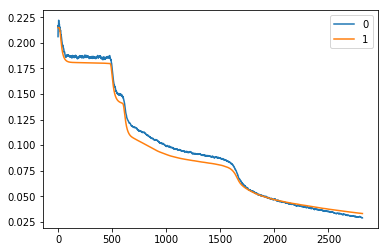

In [59]:
pd.DataFrame(losses[20:]).ewm(20).mean().plot()

In [60]:
voutputs = net.auto_encode_forward(xval)
# xval[0].cpu().data.numpy()[0]
# torch.save(net.state_dict(), 'auto_256.net')

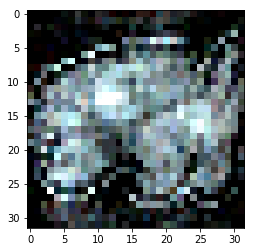

In [61]:
from matplotlib import pyplot as plt
plt.imshow(xval[1].cpu().data.numpy().transpose([1, 2, 0]))
plt.imshow(voutputs[1].cpu().data.numpy().transpose([1, 2, 0]))

Train Classifier

In [65]:
for param in net.parameters():
    param.requires_grad = False
for param in net.classifier.parameters():
    param.requires_grad = True

In [66]:
import math

N = xtrain.size ()[0]
B = 20
NB = int(math.ceil(1.0*N/B))
T = 50
# T = 1
gamma = .001
rho = .9
# Training set size # Minibacth size
# Number of minibatches # Number of epochs # learning rate
# momentum
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(net.classifier.parameters(), lr=gamma , momentum=rho)

In [67]:


losses = []
for epoch in range(T): 
    running_loss = 0.0 
    idxminibatches = np.random.permutation(NB)
    # shuffling 
    for k in range(NB): 
        i = idxminibatches[k] # index of minibatch
        # Extract i-th minibatch from xtrain and ltrain 
        
        idxsmp = np.arange(i, min(N, i+B)) # indices of samples for i-th minibatch 
        inputs = xtrain[idxsmp] 
        labels = ltrain[idxsmp]
        # Initialize the gradients to zero 
        optimizer.zero_grad ()

        # Forward propagation 
        outputs = net(inputs)
        
#         print(type(outputs.cpu().data), type(labels.cpu().data))

        # Error evaluation 
#         loss = criterion(outputs , labels)
        
        loss = criterion(outputs , torch.max(labels, 1)[1])
        
        # Back propagation 
        loss.backward()

        # Parameter update 
        optimizer.step()
        
        voutputs = net(xval)
        vloss = criterion(voutputs , torch.max(lval, 1)[1])

        # Print averaged loss per minibatch every 100 mini-batches
        running_loss+= loss[0] 
#         print(k)
        losses.append((running_loss.cpu().data.numpy()[0], vloss[0].cpu().data.numpy()[0]))
        if k % 1 == 0: 
            print('\r[%d, %5d] loss: %.8f ' % (epoch + 1, k + 1, running_loss), end="")
            running_loss = 0.0 

print ( ' Finished Training ' )
# pd.Series(losses).ewm(20).mean().plot()

[50,    28] loss: 0.60594676  Finished Training 


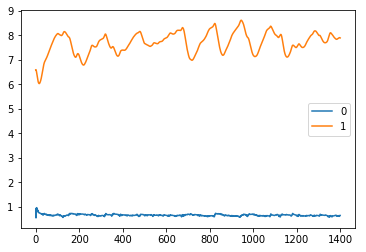

In [68]:
pd.DataFrame(losses).ewm(20).mean().plot()

In [69]:
# np.random.permutation(NB)
ytrained = net(xval)
if torch.cuda.is_available():
    ytrained = ytrained.cpu()
    
print (100 * np.mean(lval.cpu().data.numpy().T.argmax(axis=0) == ytrained.data.numpy().T.argmax(axis =0)))

6.7164179104477615


Initialized empty Git repository in /datasets/home/26/626/ee285fac/.git/
